# Modely s optimalizáciou hyperparametrov

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import Image
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [2]:
data = "finalne_data.csv"
df_final = pd.read_csv(data)
df_final.dropna(inplace = True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44053 entries, 0 to 44052
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                44053 non-null  object
 1   text                 44053 non-null  object
 2   subject              44053 non-null  object
 3   text_length          44053 non-null  int64 
 4   label                44053 non-null  object
 5   title_stem           44053 non-null  object
 6   title_lemm           44053 non-null  object
 7   text_stem            44053 non-null  object
 8   text_lemm            44053 non-null  object
 9   title_text           44053 non-null  object
 10  title_text_stem      44053 non-null  object
 11  title_text_lemm      44053 non-null  object
 12  title_hypernym       44053 non-null  object
 13  text_hypernym        44053 non-null  object
 14  title_text_hypernym  44053 non-null  object
dtypes: int64(1), object(14)
memory usage: 5.0+ MB


In [78]:
# Funkcia pre zrealizovanie GridSearch
def gridsearch(vectorizer, X_train, Y_train, X_test, Y_test):

    pipeline = Pipeline([
           ('vect', vectorizer),
           ('clf', DecisionTreeClassifier()),
    ])
    
    scoring = ['accuracy', 'precision_macro']
    
    param_dict = {
        "vect__max_features":range(10,200,20),
        "clf__criterion":['gini', 'entropy'],
    }
    
    # Funkcia GridSearchCV
    grid_search = GridSearchCV(pipeline, param_dict, cv=10, scoring=scoring, n_jobs=-1, verbose=1, refit='accuracy')
    
    grid_search.fit(X_train, Y_train)
    
    pred = grid_search.predict(X_test)
    
    df_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_accuracy"], columns=["Accuracy"])], axis=1)
    display(df_results)
    
    vectorizer = grid_search.best_estimator_.named_steps["vect"]
    clf = grid_search.best_estimator_.named_steps["clf"]
    
    features = vectorizer.get_feature_names()
    feature_importances = clf.feature_importances_
    
    data = {'feature':features, 'feature_importance':feature_importances}
    df_features = pd.DataFrame(data)
    df_features = df_features.sort_values('feature_importance', ascending = False).reset_index(drop = True)
    display(df_features[:20])
    
    fig = plt.figure(figsize =(16, 8))
    plt.bar(df_features['feature'][:10], df_features['feature_importance'][:10])
    plt.xlabel("Features")
    plt.ylabel("Feature importance")
    plt.show()
    
    # Najlepšie výsledky
    print(grid_search.best_params_)
    print("Best score: %f" % grid_search.best_score_)
    print("Accuracy: %f" % metrics.accuracy_score(Y_test, pred))
    print("Precision: %f" % metrics.precision_score(Y_test, pred, average="macro"))
    print("Recall: %f\n" % metrics.recall_score(Y_test, pred, average="macro"))

# CountVectorizer

In [20]:
def grid_count_vect(data, stopword):
    if stopword == 1:
        vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
    elif stopword == 0:
        vectorizer = CountVectorizer()

    X = data
    y = df_final.label
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    gridsearch(vectorizer, X_train, y_train, X_test, y_test)

## Title

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.1min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.735770
1,gini,30,0.782333
2,gini,50,0.809205
3,gini,70,0.810766
4,gini,90,0.819051
5,gini,110,0.825918
6,gini,130,0.835253
7,gini,150,0.837864
8,gini,170,0.842063
9,gini,190,0.846405


,feature,feature_importance
0,video,0.237577
1,watch,0.042672
2,hillary,0.038599
3,says,0.034709
4,breaking,0.018994
5,gop,0.018255
6,obama,0.016546
7,trump,0.015672
8,tweets,0.014789
9,us,0.011762


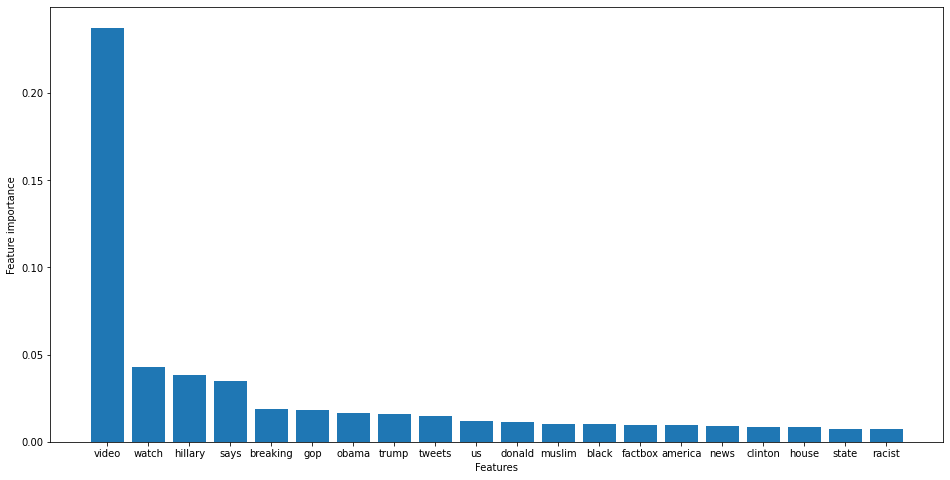

{'clf__criterion': 'entropy', 'vect__max_features': 190}
Best score: 0.846688
Accuracy: 0.845988
Precision: 0.846466
Recall: 0.846720



In [50]:
grid_count_vect(df_final.title, 1)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.735940
1,gini,30,0.783611
2,gini,50,0.808779
3,gini,70,0.822257
4,gini,90,0.825776
5,gini,110,0.833097
6,gini,130,0.837013
7,gini,150,0.840020
8,gini,170,0.845071
9,gini,190,0.849810


,feature,feature_importance
0,video,0.218284
1,watch,0.038599
2,hillari,0.035406
3,say,0.026842
4,tweet,0.020012
5,gop,0.016823
6,obama,0.016373
7,trump,0.014797
8,break,0.012456
9,us,0.010626


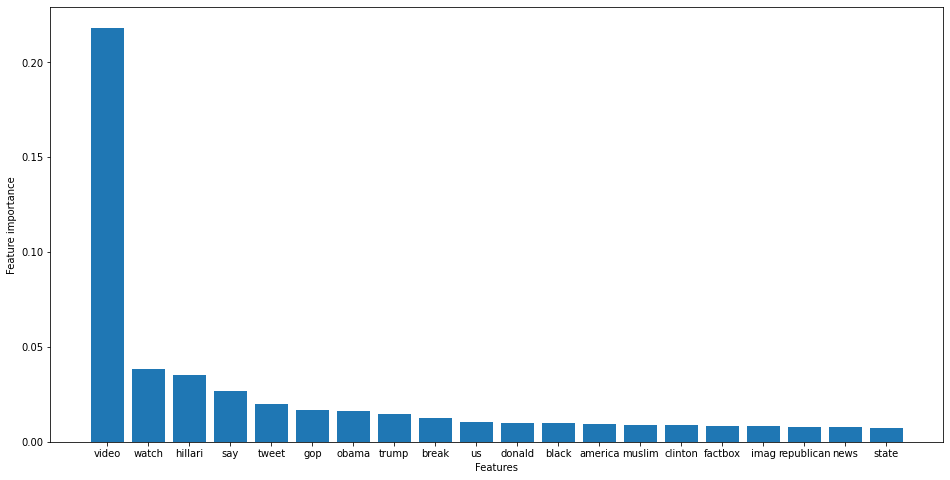

{'clf__criterion': 'entropy', 'vect__max_features': 190}
Best score: 0.851200
Accuracy: 0.855748
Precision: 0.855675
Recall: 0.856071



In [51]:
grid_count_vect(df_final.title_stem, 0)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.734607
1,gini,30,0.791159
2,gini,50,0.814823
3,gini,70,0.820754
4,gini,90,0.825180
5,gini,110,0.828415
6,gini,130,0.830628
7,gini,150,0.834572
8,gini,170,0.840332
9,gini,190,0.843482


,feature,feature_importance
0,video,0.220611
1,watch,0.038977
2,hillary,0.035793
3,say,0.023462
4,tweet,0.020309
5,gop,0.016870
6,obama,0.016368
7,break,0.013008
8,trump,0.012744
9,get,0.010412


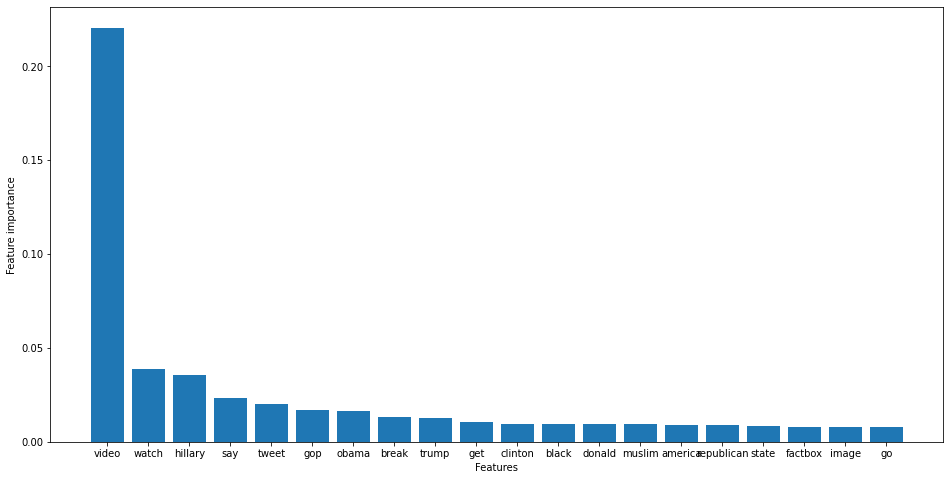

{'clf__criterion': 'entropy', 'vect__max_features': 190}
Best score: 0.847795
Accuracy: 0.846328
Precision: 0.846123
Recall: 0.846307



In [52]:
grid_count_vect(df_final.title_lemm, 0)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.5min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.702089
1,gini,30,0.769394
2,gini,50,0.777425
3,gini,70,0.787981
4,gini,90,0.808666
5,gini,110,0.817122
6,gini,130,0.827053
7,gini,150,0.830855
8,gini,170,0.834203
9,gini,190,0.833125


,feature,feature_importance
0,visual,0.197961
1,timepiece,0.035014
2,hillary,0.032499
3,says,0.028536
4,chirp,0.017982
5,information,0.015858
6,obama,0.015206
7,party,0.014163
8,breaking,0.014113
9,person,0.012728


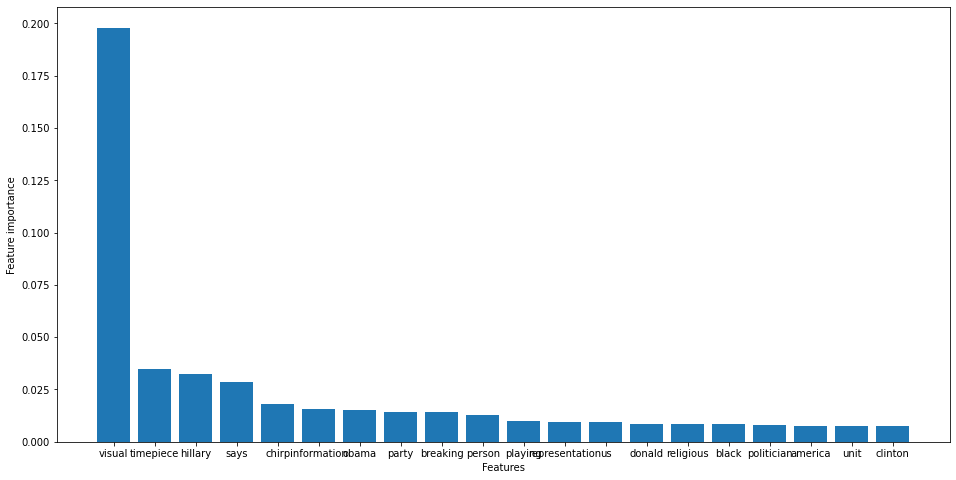

{'clf__criterion': 'entropy', 'vect__max_features': 190}
Best score: 0.837495
Accuracy: 0.843264
Precision: 0.843590
Recall: 0.842576



In [53]:
grid_count_vect(df_final.title_hypernym, 0)

## Text

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 22.5min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.969410
1,gini,30,0.989189
2,gini,50,0.990494
3,gini,70,0.992594
4,gini,90,0.992452
5,gini,110,0.993133
6,gini,130,0.993218
7,gini,150,0.993757
8,gini,170,0.993786
9,gini,190,0.994240


,feature,feature_importance
0,reuters,0.969035
1,image,0.004170
2,via,0.003961
3,said,0.001771
4,us,0.001694
5,obama,0.001276
6,hillary,0.000710
7,media,0.000683
8,news,0.000667
9,man,0.000569


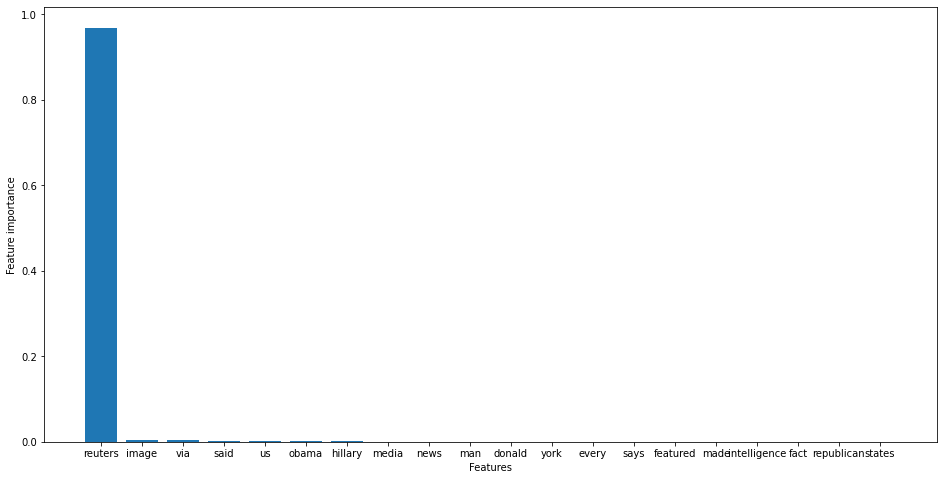

{'clf__criterion': 'gini', 'vect__max_features': 190}
Best score: 0.994240
Accuracy: 0.993985
Precision: 0.993997
Recall: 0.993959



In [54]:
grid_count_vect(df_final.text, 1)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 14.8min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.804211
1,gini,30,0.988536
2,gini,50,0.989217
3,gini,70,0.989955
4,gini,90,0.992254
5,gini,110,0.993757
6,gini,130,0.993757
7,gini,150,0.993729
8,gini,170,0.993587
9,gini,190,0.993275


,feature,feature_importance
0,reuter,0.969035
1,via,0.004123
2,imag,0.003567
3,said,0.003241
4,us,0.001946
5,obama,0.001315
6,state,0.000872
7,news,0.000778
8,hillari,0.000753
9,plan,0.000557


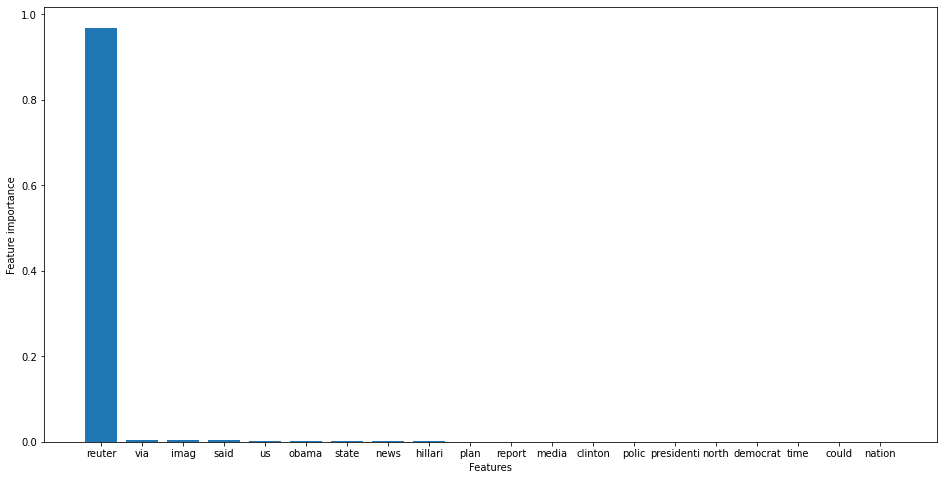

{'clf__criterion': 'gini', 'vect__max_features': 110}
Best score: 0.993757
Accuracy: 0.993758
Precision: 0.993786
Recall: 0.993716



In [55]:
grid_count_vect(df_final.text_stem, 0)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 14.9min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.778985
1,gini,30,0.989416
2,gini,50,0.989785
3,gini,70,0.989927
4,gini,90,0.991885
5,gini,110,0.992849
6,gini,130,0.992793
7,gini,150,0.993275
8,gini,170,0.993303
9,gini,190,0.993105


,feature,feature_importance
0,reuters,0.938096
1,via,0.013652
2,image,0.004971
3,say,0.003848
4,obama,0.002693
5,news,0.002271
6,america,0.001304
7,clinton,0.000973
8,washington,0.000892
9,trump,0.000879


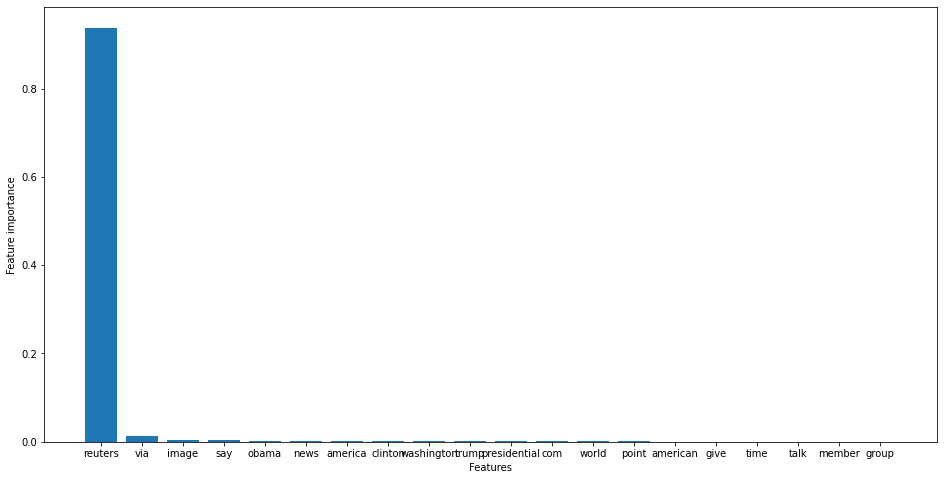

{'clf__criterion': 'entropy', 'vect__max_features': 190}
Best score: 0.994211
Accuracy: 0.994098
Precision: 0.994115
Recall: 0.994069



In [56]:
grid_count_vect(df_final.text_lemm, 0)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 17.2min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.787951
1,gini,30,0.854179
2,gini,50,0.964530
3,gini,70,0.990608
4,gini,90,0.992424
5,gini,110,0.992055
6,gini,130,0.991800
7,gini,150,0.991913
8,gini,170,0.992934
9,gini,190,0.993133


,feature,feature_importance
0,reuters,0.938096
1,via,0.013652
2,said,0.005119
3,us,0.004011
4,representation,0.003597
5,obama,0.001984
6,information,0.001422
7,presidential,0.001017
8,according,0.000981
9,operation,0.000908


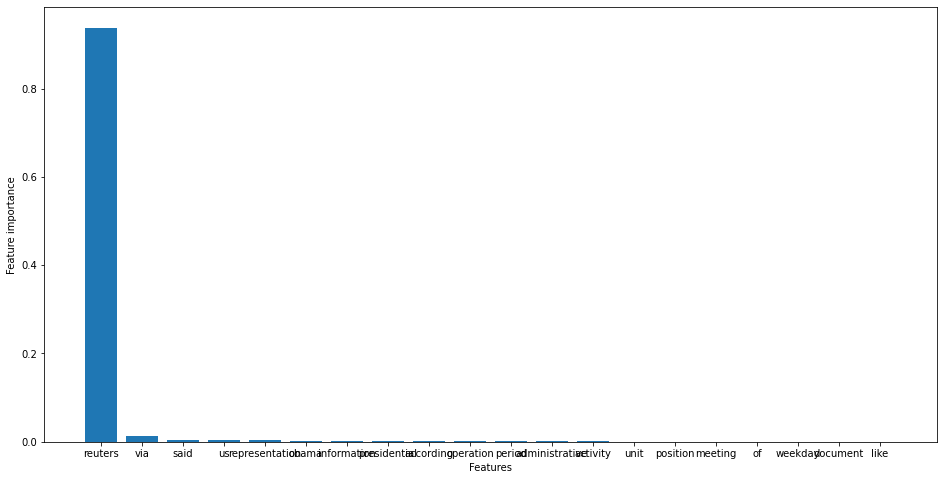

{'clf__criterion': 'entropy', 'vect__max_features': 170}
Best score: 0.993729
Accuracy: 0.994098
Precision: 0.994099
Recall: 0.994084



In [57]:
grid_count_vect(df_final.text_hypernym, 0)

## Title + Text

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 24.0min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.807757
1,gini,30,0.989870
2,gini,50,0.991260
3,gini,70,0.991062
4,gini,90,0.993190
5,gini,110,0.994240
6,gini,130,0.994013
7,gini,150,0.993672
8,gini,170,0.994240
9,gini,190,0.994013


,feature,feature_importance
0,reuters,0.938096
1,via,0.013614
2,us,0.004608
3,image,0.004076
4,said,0.003276
5,obama,0.002371
6,featured,0.001933
7,news,0.001776
8,video,0.001348
9,court,0.001035


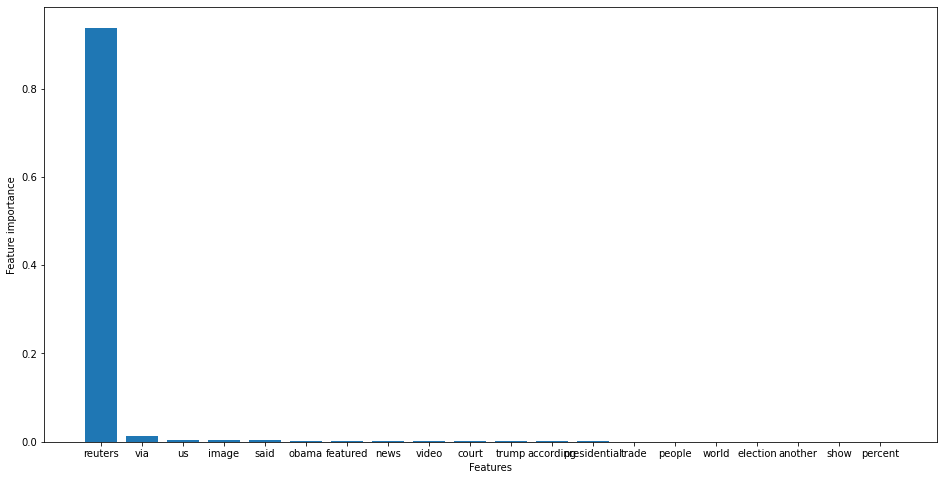

{'clf__criterion': 'entropy', 'vect__max_features': 190}
Best score: 0.994921
Accuracy: 0.995120
Precision: 0.995142
Recall: 0.995087



In [58]:
grid_count_vect(df_final.title_text, 1)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 14.9min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.801799
1,gini,30,0.988678
2,gini,50,0.989700
3,gini,70,0.991175
4,gini,90,0.992708
5,gini,110,0.994098
6,gini,130,0.993899
7,gini,150,0.993956
8,gini,170,0.994013
9,gini,190,0.994297


,feature,feature_importance
0,reuter,0.938199
1,via,0.013716
2,said,0.005523
3,imag,0.004915
4,us,0.004413
5,obama,0.002434
6,report,0.001888
7,news,0.001484
8,video,0.001312
9,presidenti,0.001218


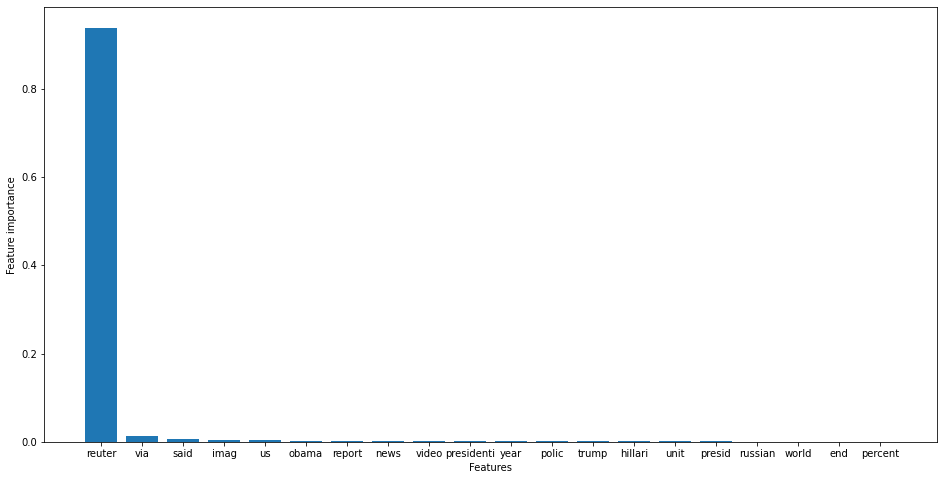

{'clf__criterion': 'entropy', 'vect__max_features': 150}
Best score: 0.994438
Accuracy: 0.995574
Precision: 0.995551
Recall: 0.995588



In [59]:
grid_count_vect(df_final.title_text_stem, 0)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 15.0min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.781000
1,gini,30,0.988678
2,gini,50,0.990381
3,gini,70,0.990892
4,gini,90,0.991885
5,gini,110,0.993275
6,gini,130,0.994410
7,gini,150,0.993474
8,gini,170,0.993928
9,gini,190,0.993786


,feature,feature_importance
0,reuters,0.969035
1,image,0.003910
2,via,0.003837
3,say,0.003004
4,obama,0.001709
5,donald,0.000942
6,medium,0.000790
7,state,0.000771
8,presidential,0.000722
9,hillary,0.000604


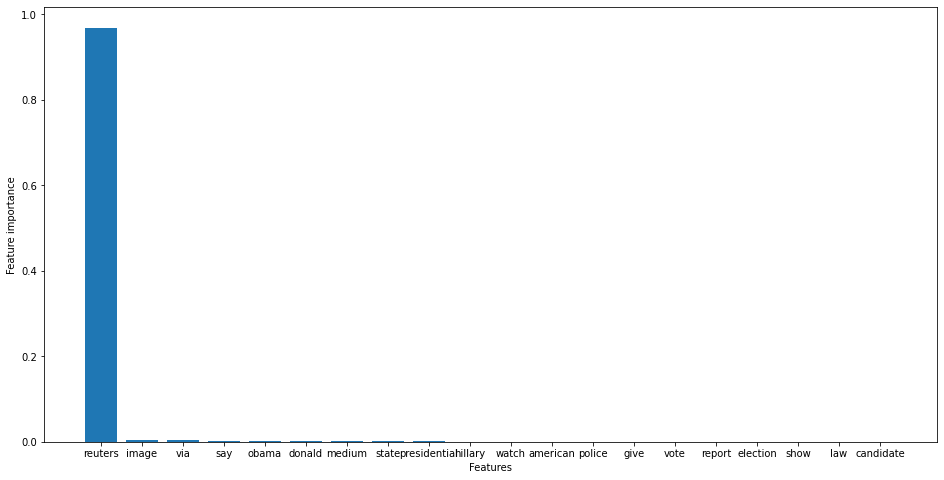

{'clf__criterion': 'gini', 'vect__max_features': 130}
Best score: 0.994410
Accuracy: 0.994325
Precision: 0.994350
Recall: 0.994288



In [60]:
grid_count_vect(df_final.title_text_lemm, 0)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 16.9min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.787384
1,gini,30,0.852846
2,gini,50,0.876766
3,gini,70,0.989927
4,gini,90,0.991885
5,gini,110,0.991771
6,gini,130,0.991856
7,gini,150,0.991573
8,gini,170,0.992708
9,gini,190,0.993303


,feature,feature_importance
0,reuters,0.938096
1,via,0.013971
2,said,0.004753
3,us,0.004117
4,representation,0.003612
5,obama,0.002096
6,information,0.001232
7,weekday,0.001217
8,position,0.001182
9,presidential,0.000978


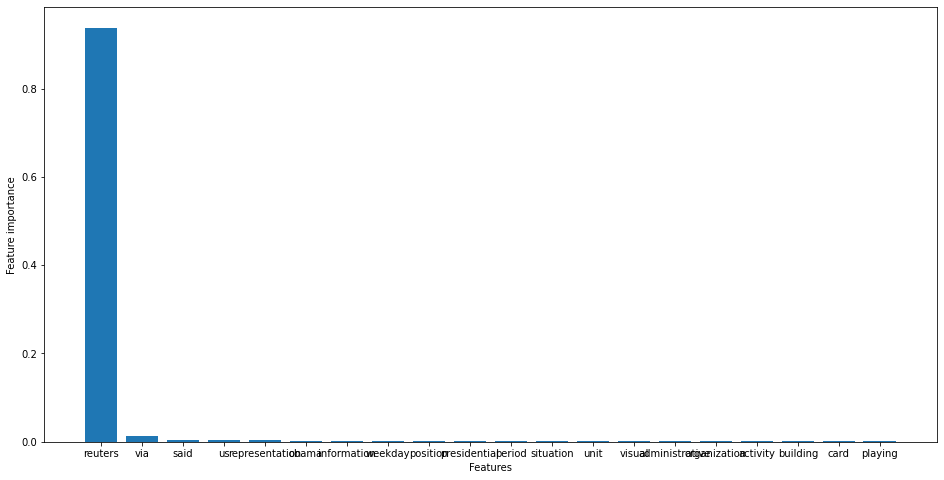

{'clf__criterion': 'entropy', 'vect__max_features': 190}
Best score: 0.994921
Accuracy: 0.995120
Precision: 0.995134
Recall: 0.995095



In [61]:
grid_count_vect(df_final.title_text_hypernym, 0)

# TfidfVectorizer

In [79]:
def grid_tfidf_vect(data, stopword):
    if stopword == 1:
        vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
    elif stopword == 0:
        vectorizer = TfidfVectorizer()

    X = data
    y = df_final.label
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    gridsearch(vectorizer, X_train, y_train, X_test, y_test)

## Title

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.6min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.735827
1,gini,30,0.780745
2,gini,50,0.807531
3,gini,70,0.809602
4,gini,90,0.817491
5,gini,110,0.825039
6,gini,130,0.833948
7,gini,150,0.838091
8,gini,170,0.839992
9,gini,190,0.846008


,feature,feature_importance
0,video,0.246966
1,watch,0.048643
2,hillary,0.045578
3,says,0.037001
4,trump,0.027165
5,obama,0.026537
6,gop,0.021088
7,breaking,0.018915
8,tweets,0.017388
9,donald,0.013911


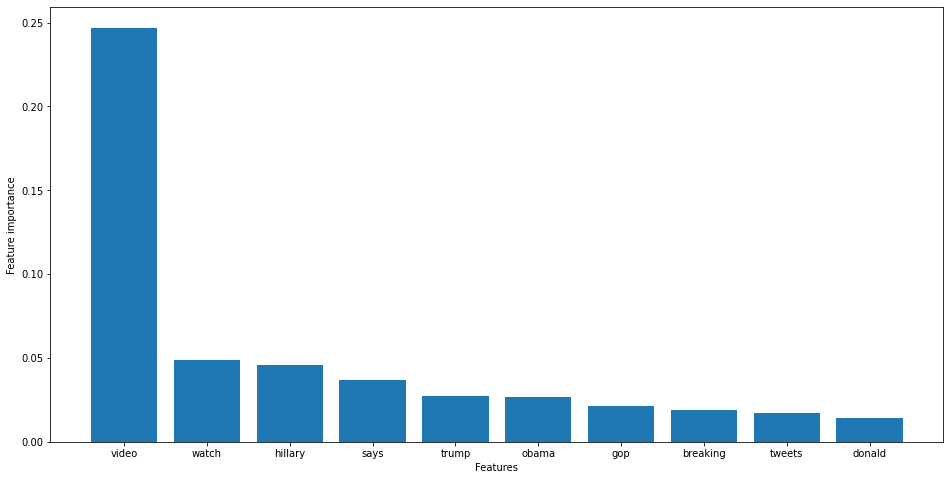

{'clf__criterion': 'gini', 'vect__max_features': 190}
Best score: 0.846008
Accuracy: 0.846442
Precision: 0.846949
Recall: 0.847190



In [80]:
grid_tfidf_vect(df_final.title, 1)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.7min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.735969
1,gini,30,0.782674
2,gini,50,0.807900
3,gini,70,0.820328
4,gini,90,0.825776
5,gini,110,0.832671
6,gini,130,0.835509
7,gini,150,0.839822
8,gini,170,0.844986
9,gini,190,0.850718


,feature,feature_importance
0,video,0.220825
1,watch,0.038623
2,hillari,0.035645
3,say,0.030617
4,trump,0.030331
5,obama,0.022140
6,tweet,0.020349
7,gop,0.016813
8,break,0.013935
9,donald,0.010752


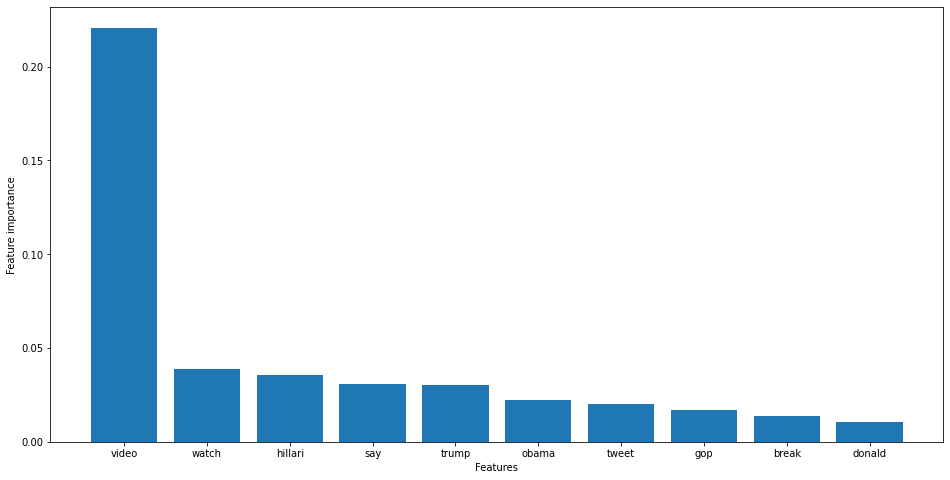

{'clf__criterion': 'entropy', 'vect__max_features': 190}
Best score: 0.851143
Accuracy: 0.855408
Precision: 0.855344
Recall: 0.855741



In [81]:
grid_tfidf_vect(df_final.title_stem, 0)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.7min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.734181
1,gini,30,0.789541
2,gini,50,0.813632
3,gini,70,0.819704
4,gini,90,0.824528
5,gini,110,0.829096
6,gini,130,0.831423
7,gini,150,0.838317
8,gini,170,0.843085
9,gini,190,0.847738


,feature,feature_importance
0,video,0.231592
1,watch,0.045173
2,hillary,0.042231
3,say,0.030001
4,trump,0.027540
5,obama,0.025714
6,tweet,0.024625
7,gop,0.018997
8,break,0.016765
9,get,0.014123


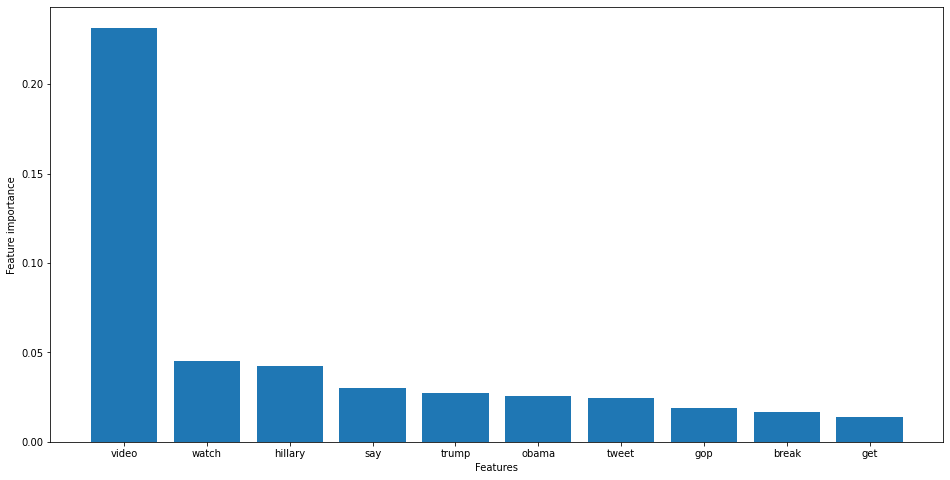

{'clf__criterion': 'gini', 'vect__max_features': 190}
Best score: 0.847738
Accuracy: 0.849052
Precision: 0.848890
Recall: 0.849225



In [82]:
grid_tfidf_vect(df_final.title_lemm, 0)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.6min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.701436
1,gini,30,0.767749
2,gini,50,0.775495
3,gini,70,0.787186
4,gini,90,0.811646
5,gini,110,0.821179
6,gini,130,0.829493
7,gini,150,0.830770
8,gini,170,0.837807
9,gini,190,0.839737


,feature,feature_importance
0,visual,0.199163
1,timepiece,0.035546
2,hillary,0.032649
3,says,0.031108
4,obama,0.022133
5,playing,0.018967
6,chirp,0.018311
7,information,0.017530
8,party,0.014032
9,breaking,0.013388


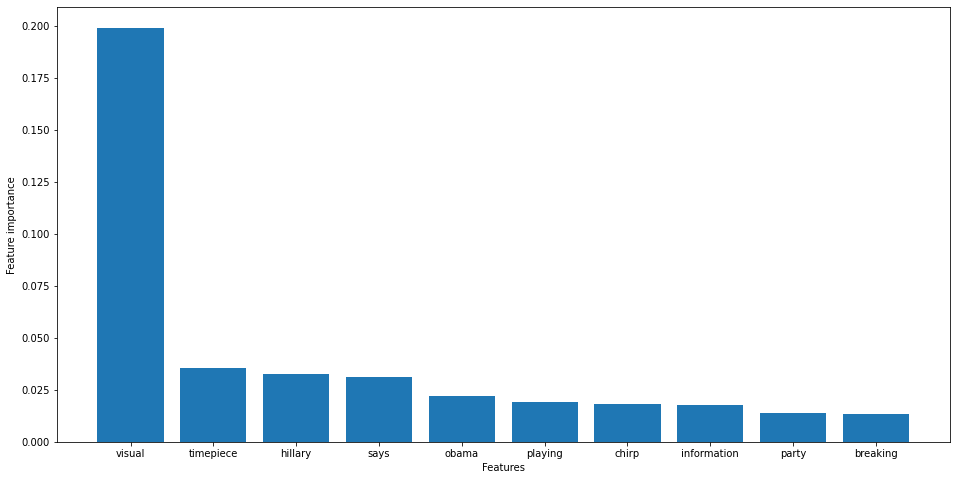

{'clf__criterion': 'entropy', 'vect__max_features': 190}
Best score: 0.841212
Accuracy: 0.849166
Precision: 0.849081
Recall: 0.848845



In [83]:
grid_tfidf_vect(df_final.title_hypernym, 0)

## Text

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 22.3min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.970432
1,gini,30,0.990665
2,gini,50,0.992140
3,gini,70,0.992963
4,gini,90,0.993190
5,gini,110,0.993559
6,gini,130,0.994155
7,gini,150,0.994268
8,gini,170,0.994637
9,gini,190,0.994751


,feature,feature_importance
0,reuters,0.969958
1,image,0.004334
2,via,0.003615
3,obama,0.001460
4,us,0.001400
5,said,0.000901
6,says,0.000776
7,federal,0.000742
8,group,0.000702
9,media,0.000679


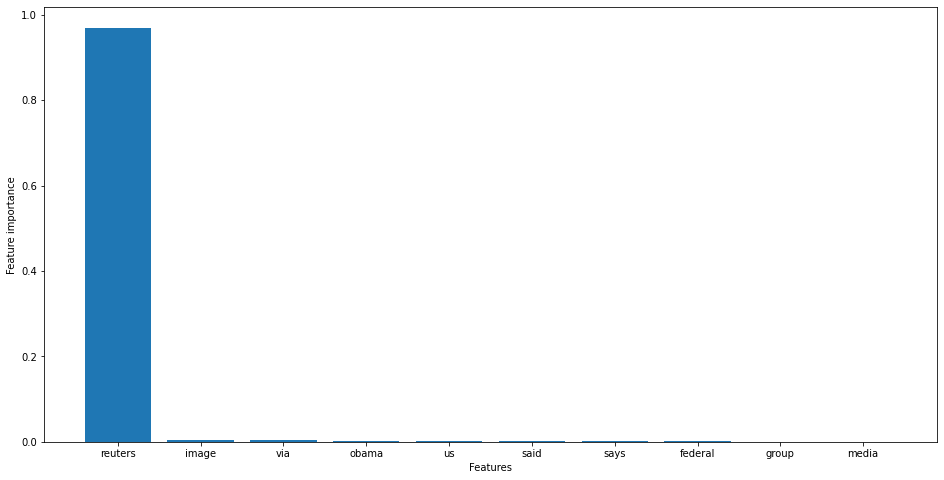

{'clf__criterion': 'gini', 'vect__max_features': 190}
Best score: 0.994751
Accuracy: 0.995460
Precision: 0.995455
Recall: 0.995455



In [84]:
grid_tfidf_vect(df_final.text, 1)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 15.2min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.807020
1,gini,30,0.990551
2,gini,50,0.990523
3,gini,70,0.991714
4,gini,90,0.992651
5,gini,110,0.994126
6,gini,130,0.993843
7,gini,150,0.994552
8,gini,170,0.994722
9,gini,190,0.993843


,feature,feature_importance
0,reuter,0.970782
1,imag,0.003625
2,via,0.003574
3,obama,0.001782
4,us,0.001743
5,said,0.001269
6,anoth,0.000734
7,news,0.000729
8,polic,0.000685
9,group,0.000681


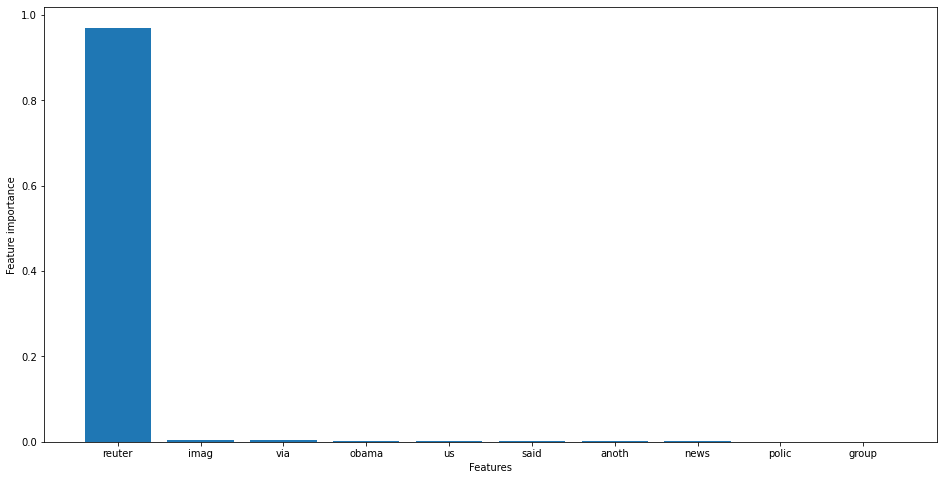

{'clf__criterion': 'gini', 'vect__max_features': 170}
Best score: 0.994722
Accuracy: 0.994212
Precision: 0.994258
Recall: 0.994155



In [85]:
grid_tfidf_vect(df_final.text_stem, 0)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 15.3min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.774587
1,gini,30,0.990211
2,gini,50,0.991260
3,gini,70,0.991686
4,gini,90,0.992424
5,gini,110,0.994098
6,gini,130,0.993814
7,gini,150,0.993417
8,gini,170,0.993303
9,gini,190,0.993417


,feature,feature_importance
0,reuters,0.938968
1,via,0.013776
2,say,0.005718
3,image,0.005102
4,news,0.003208
5,obama,0.002122
6,accord,0.001576
7,united,0.001290
8,like,0.001133
9,clinton,0.000968


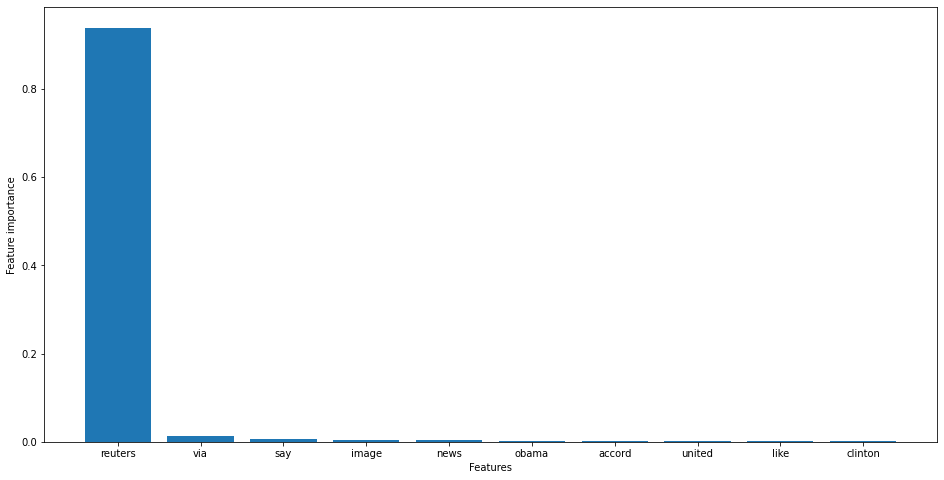

{'clf__criterion': 'entropy', 'vect__max_features': 130}
Best score: 0.994268
Accuracy: 0.994325
Precision: 0.994385
Recall: 0.994258



In [86]:
grid_tfidf_vect(df_final.text_lemm, 0)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 18.3min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.784093
1,gini,30,0.855797
2,gini,50,0.966005
3,gini,70,0.991147
4,gini,90,0.991459
5,gini,110,0.992736
6,gini,130,0.992055
7,gini,150,0.992679
8,gini,170,0.993644
9,gini,190,0.993502


,feature,feature_importance
0,reuters,0.938707
1,via,0.013643
2,said,0.006428
3,us,0.004241
4,obama,0.002088
5,representation,0.001677
6,agent,0.001647
7,weekday,0.001472
8,system,0.001428
9,worker,0.001305


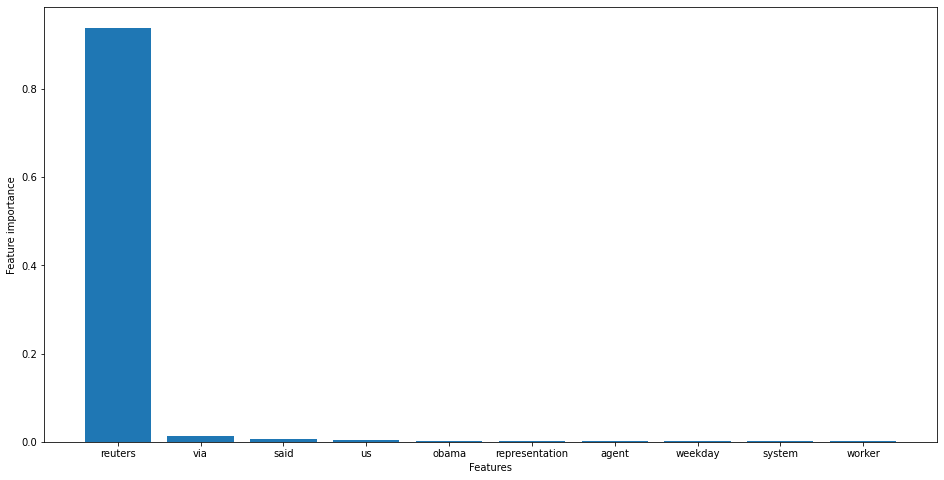

{'clf__criterion': 'entropy', 'vect__max_features': 170}
Best score: 0.993871
Accuracy: 0.994779
Precision: 0.994781
Recall: 0.994766



In [87]:
grid_tfidf_vect(df_final.text_hypernym, 0)

## Title + Text

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 24.0min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.810027
1,gini,30,0.990636
2,gini,50,0.992594
3,gini,70,0.992736
4,gini,90,0.993757
5,gini,110,0.993956
6,gini,130,0.994211
7,gini,150,0.994211
8,gini,170,0.994070
9,gini,190,0.993843


,feature,feature_importance
0,reuters,0.938968
1,via,0.013340
2,said,0.004424
3,us,0.003747
4,image,0.003340
5,obama,0.002666
6,featured,0.002412
7,news,0.001922
8,video,0.001724
9,vote,0.001072


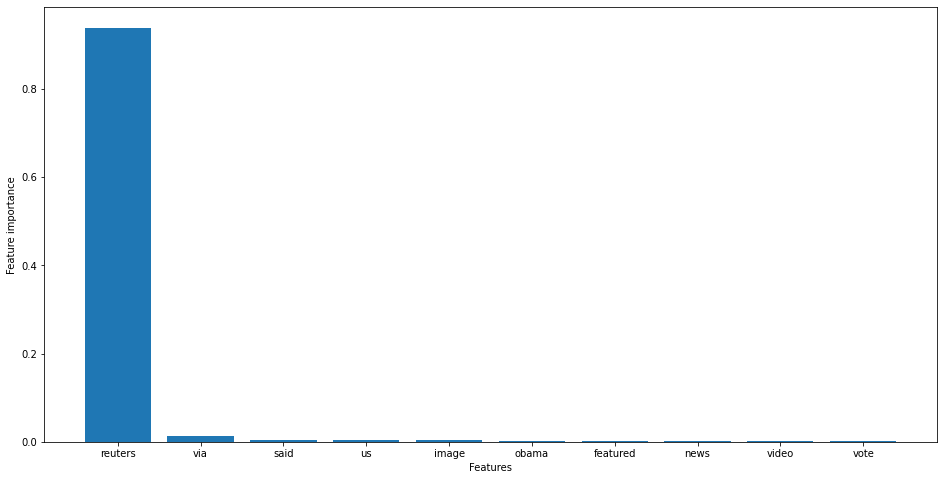

{'clf__criterion': 'entropy', 'vect__max_features': 150}
Best score: 0.994722
Accuracy: 0.996028
Precision: 0.996051
Recall: 0.995996



In [88]:
grid_tfidf_vect(df_final.title_text, 1)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 15.7min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.798677
1,gini,30,0.990806
2,gini,50,0.990693
3,gini,70,0.991232
4,gini,90,0.992878
5,gini,110,0.993474
6,gini,130,0.993928
7,gini,150,0.993984
8,gini,170,0.994041
9,gini,190,0.993956


,feature,feature_importance
0,reuter,0.939535
1,via,0.013147
2,said,0.006558
3,us,0.003652
4,featur,0.002348
5,imag,0.002265
6,video,0.001694
7,obama,0.001410
8,like,0.001258
9,media,0.001141


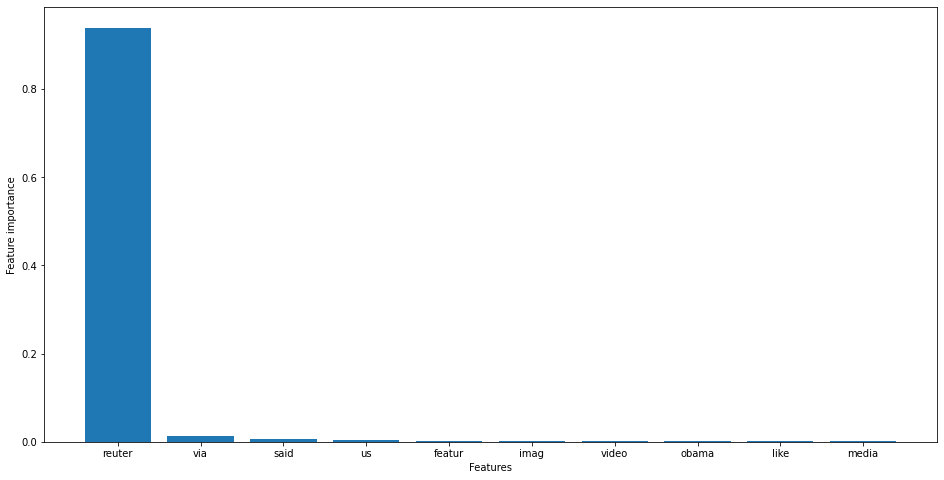

{'clf__criterion': 'entropy', 'vect__max_features': 190}
Best score: 0.994297
Accuracy: 0.995233
Precision: 0.995243
Recall: 0.995212



In [89]:
grid_tfidf_vect(df_final.title_text_stem, 0)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 16.0min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.777623
1,gini,30,0.990579
2,gini,50,0.990721
3,gini,70,0.991346
4,gini,90,0.992509
5,gini,110,0.993729
6,gini,130,0.993814
7,gini,150,0.993587
8,gini,170,0.992991
9,gini,190,0.993757


,feature,feature_importance
0,reuters,0.939162
1,via,0.013569
2,say,0.005780
3,image,0.003720
4,news,0.002749
5,video,0.002644
6,like,0.002159
7,obama,0.001637
8,report,0.001623
9,take,0.001198


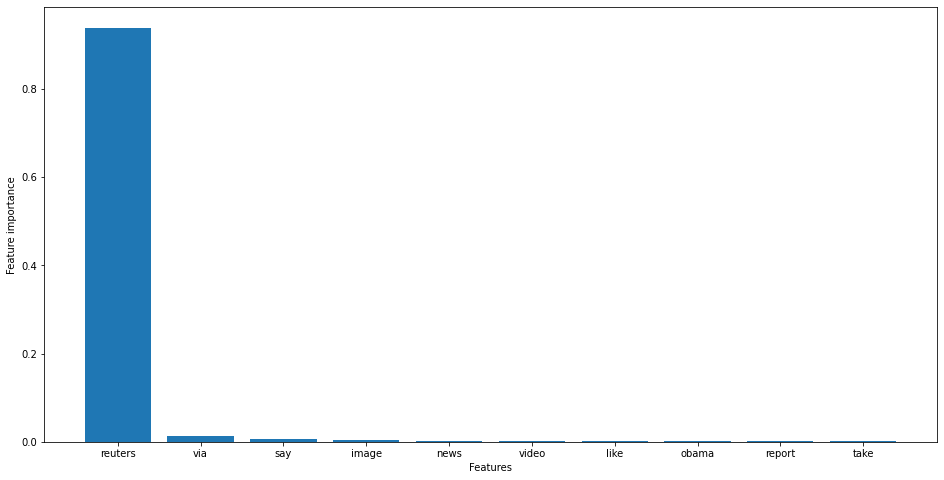

{'clf__criterion': 'entropy', 'vect__max_features': 130}
Best score: 0.994325
Accuracy: 0.993304
Precision: 0.993340
Recall: 0.993254



In [90]:
grid_tfidf_vect(df_final.title_text_lemm, 0)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 19.0min finished


,clf__criterion,vect__max_features,Accuracy
0,gini,10,0.784830
1,gini,30,0.856109
2,gini,50,0.873617
3,gini,70,0.990551
4,gini,90,0.991998
5,gini,110,0.991743
6,gini,130,0.992055
7,gini,150,0.992253
8,gini,170,0.993672
9,gini,190,0.993701


,feature,feature_importance
0,reuters,0.938778
1,via,0.013617
2,said,0.006870
3,us,0.004477
4,weekday,0.001822
5,obama,0.001756
6,visual,0.001716
7,information,0.001483
8,representation,0.001331
9,being,0.001306


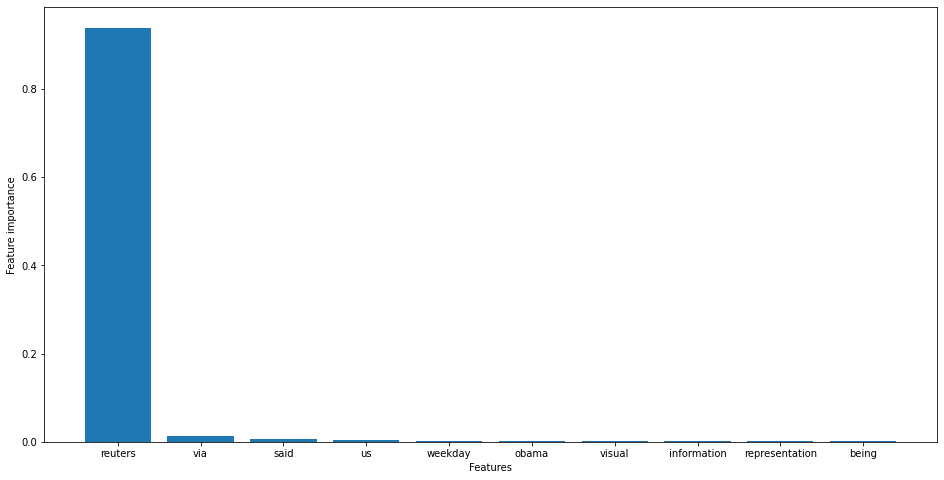

{'clf__criterion': 'entropy', 'vect__max_features': 190}
Best score: 0.994438
Accuracy: 0.993190
Precision: 0.993206
Recall: 0.993160



In [91]:
grid_tfidf_vect(df_final.title_text_hypernym, 0)